In [77]:
from Bio import Entrez
import os
from Bio import Medline
Entrez.email = "NCBI_EMAIL", "your.email@yourdomain""
Entrez.api_key = os.getenv("NCBI_API_KEY")  
RATE_LIMIT = 0.34   # seconds between requests  (≈3/sec)
from tqdm import tqdm
import pandas as pd
import sqlite3
import xlrd
import plotly.graph_objects as go
import time
from retrying import retry
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [55]:


def get_count(term):
    """
    Use pubmed API to get a count of number of results for a search term
    """
    count_handle = Entrez.esearch(db="pubmed",
                                  sort="relevance",
                                  retmode="xml",
                                  retmax=0,  # Request only the count
                                  term=term)
    count_results = Entrez.read(count_handle)
    count = int(count_results["Count"])
    
    return count


def chunked_pmids(term, chunksize):
    """
    Use pubmed API to fetch blocks of PMIDs for a search term
    """
    
    count = get_count(term)
    
    retmax_requests = list(range(0, count, chunksize))
                
    pmids = []
    
    print(f"{len(retmax_requests)} blocks to process, total papers count: {count}")
    
    for i, retmax in enumerate(retmax_requests):
        
        print(f"Processing block {i + 1}/{len(retmax_requests)}")
        
        try: 
            pmid_handle = Entrez.esearch(db="pubmed",
                                         sort="relevance",
                                         retmode="xml",
                                         usehistory='y',
                                         retstart=retmax,
                                         retmax=chunksize,
                                         term=term)
            result = Entrez.read(pmid_handle)
            id_list = result["IdList"]
            
            # Check if the IdList is empty
            if not id_list:
                print(f"No PMIDs found for block {i + 1}")
                continue
            
            pmids.append(id_list)
            time.sleep(RATE_LIMIT)

        
        except Exception as e:
            print(f"Error fetching block {i}: {e}")
            continue
            
        # Add a delay to respect API rate limits
        time.sleep(5)  # Adjust the delay as needed based on API limits
            
    return pmids

def fetch_medline(pmids):
    """
    Use pubmed api to fetch medline record for pmids
    """
    handle = Entrez.efetch(db='pubmed',
                           id=pmids,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    
    return records
    

def save_new_papers(papers):
    """
    Save only new papers (that are not already in the database) to the SQLite database.
    """
    conn = sqlite3.connect('papers.db')
    c = conn.cursor()

    # Create table if it doesn't already exist
    c.execute('''CREATE TABLE IF NOT EXISTS papers
                 (pmid TEXT PRIMARY KEY, author TEXT, author_affiliation TEXT, date TEXT, 
                 title TEXT, journal TEXT, pub_type TEXT)''')

    # Fetch existing PMIDs from the database
    existing_pmids = set(row[0] for row in c.execute('SELECT pmid FROM papers').fetchall())

    new_papers = []
    for paper in papers:
        pmid = paper[0]
        if pmid not in existing_pmids:
            new_papers.append(paper)

    # Insert new papers into the database
    if new_papers:
        c.executemany('INSERT INTO papers VALUES (?,?,?,?,?,?,?)', new_papers)
        conn.commit()
        print(f"{len(new_papers)} new papers added to the database.")
    else:
        print("No new papers to add.")

    conn.close()

def getpapers(pmid_chunks, max_retries=10):
    """
    Fetch medline records for PMIDs with a retry mechanism if an error occurs.
    Append newly found complete papers to the database.
    """
    papers = []
    notpapers = []

    print("Fetching MEDLINE records:")

    total_fetched = 0  # To track total number of papers processed

    for i, chunk in enumerate(tqdm(pmid_chunks)):
        retries = 0
        success = False

        while retries < max_retries and not success:
            try:
                print(f"Fetching chunk {i + 1}/{len(pmid_chunks)} (attempt {retries + 1})")
                records = fetch_medline(chunk)
                time.sleep(RATE_LIMIT)
                records_list = list(records)  # Convert generator to list to count easily
                chunk_size = len(records_list)
                print(f"Fetched {chunk_size} records for chunk {i + 1}/{len(pmid_chunks)}")

                total_fetched += chunk_size

                for record in records_list:
                    try:
                        paper = (
                            record['PMID'], 
                            ', '.join(record.get('AU', ['Unknown'])), 
                            ', '.join(record.get('AD', ['Unknown'])),
                            record.get('DP', 'Unknown'), 
                            record.get('TI', 'Unknown'), 
                            record.get('JT', 'Unknown'), 
                            ', '.join(record.get('PT', ['Unknown']))
                        )
                        # Check if paper has missing fields
                        if 'Unknown' not in paper:
                            papers.append(paper)  # Add to the list of complete papers
                        else:
                            notpapers.append(record)  # Incomplete record
                    except KeyError as e:
                        print(f"Missing field {e} in record with PMID {record.get('PMID', 'N/A')}")
                        notpapers.append(record)
                        continue

                success = True

            except Exception as e:
                retries += 1
                print(f"Error fetching chunk {i + 1}: {e}. Retrying {retries}/{max_retries}...")
                time.sleep(2)  # Wait for 2 seconds before retrying

        if not success:
            print(f"Failed to fetch chunk {i + 1} after {max_retries} attempts. Skipping...")

    print(f"Total fetched records: {total_fetched}")
    print(f"Total complete papers: {len(papers)}")
    print(f"Total papers with missing fields: {len(notpapers)}")

    # Save only new, complete papers to the database
    save_new_papers(papers)

    return papers, notpapers

    

def save_papers(papers):
    """
    Save our papers to an sqlite database
    """
    conn = sqlite3.connect('papers.db')
    c = conn.cursor()
    
    # Drop table if already exists
    c.execute("DROP TABLE IF EXISTS papers")
    
    # Create table
    c.execute('''CREATE TABLE papers
             (pmid, author, author_affiliation, date, title, journal, pub_type)''')

    # Insert a rows of data
    c.executemany('INSERT INTO papers VALUES (?,?,?,?,?,?,?)', papers)

    # Save (commit) the changes
    conn.commit()

    # We can also close the connection if we are done with it.
    # Just be sure any changes have been committed or they will be lost.
    conn.close()
    
def df_from_papers_database():
    """
    Load our papers
    """
    conn = sqlite3.connect('papers.db')
    df = pd.read_sql_query('SELECT * FROM papers', conn)
    conn.close()  # Close the connection
    return df

def fetch_papers(term):
    """
    Fetch our papers
    """
    print("{} records to fetch".format(get_count(term)))
    pmid_chunks = chunked_pmids(term, 500)
    papers, notpapers = getpapers(pmid_chunks)
    
    return papers, notpapers

def homerton_affiliation_term():
    # Add variants you commonly see in PubMed affiliation strings
    variants = [
        "Homerton University Hospital",
        "Homerton Healthcare",
        "Homerton University Hospital NHS Foundation Trust",
        "Homerton Healthcare NHS Foundation Trust",
        "Homerton Hospital",
        # "HUH",  # optional; can add noise, but sometimes appears
        "Homerton Row",
        "Homerton University Hospital, London",
    ]
    # [AD] = affiliation/address field in PubMed query syntax
    return "(" + " OR ".join([f"\"{v}\"[AD]" for v in variants]) + ")"

In [56]:
# run first time only
papers, notpapers = fetch_papers(homerton_affiliation_term())
save_papers(papers)
df = df_from_papers_database()

1557 records to fetch
4 blocks to process, total papers count: 1557
Processing block 1/4
Processing block 2/4
Processing block 3/4
Processing block 4/4
Fetching MEDLINE records:


  0%|                                                                                                                                                                                                           | 0/4 [00:00<?, ?it/s]

Fetching chunk 1/4 (attempt 1)


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 1/4 [00:04<00:12,  4.08s/it]

Fetched 500 records for chunk 1/4
Fetching chunk 2/4 (attempt 1)


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2/4 [00:06<00:06,  3.37s/it]

Fetched 500 records for chunk 2/4
Fetching chunk 3/4 (attempt 1)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3/4 [00:11<00:03,  3.83s/it]

Fetched 500 records for chunk 3/4
Fetching chunk 4/4 (attempt 1)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.32s/it]

Fetched 57 records for chunk 4/4
Total fetched records: 1557
Total complete papers: 1555
Total papers with missing fields: 2
No new papers to add.


In [57]:
# update
papers, notpapers = fetch_papers(homerton_affiliation_term())
save_new_papers(papers)
df = df_from_papers_database()

1557 records to fetch
4 blocks to process, total papers count: 1557
Processing block 1/4
Processing block 2/4
Processing block 3/4
Processing block 4/4
Fetching MEDLINE records:


  0%|                                                                                                                                                                                                           | 0/4 [00:00<?, ?it/s]

Fetching chunk 1/4 (attempt 1)


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 1/4 [00:06<00:20,  6.79s/it]

Fetched 500 records for chunk 1/4
Fetching chunk 2/4 (attempt 1)


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 2/4 [00:09<00:08,  4.43s/it]

Fetched 500 records for chunk 2/4
Fetching chunk 3/4 (attempt 1)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3/4 [00:13<00:04,  4.22s/it]

Fetched 500 records for chunk 3/4
Fetching chunk 4/4 (attempt 1)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.88s/it]

Fetched 57 records for chunk 4/4
Total fetched records: 1557
Total complete papers: 1555
Total papers with missing fields: 2
No new papers to add.
No new papers to add.


In [58]:
pd.set_option('display.max_rows', None)
df[df['author'].str.contains('Reynolds C|Anderson J|Fleming P|Malik H', regex=True, na=False)].sort_values(by='date', ascending=False)

,pmid,author,author_affiliation,date,title,journal,pub_type
385,41536855,"Aveline A, Szatkowski L, Berrington J, Costelo...","Neonatal Medicine, School of Public Health, Fa...",2026 Mar,Evaluating the effect of probiotics on severe ...,The Lancet regional health. Europe,Journal Article
489,41212985,"Willis K, Shakespeare R, Chandrasekaran L, Cha...","School of Health and Medical Sciences, Departm...",2026 Jan,What are the perceptions and concerns of peopl...,Diabetic medicine : a journal of the British D...,Journal Article
1401,40478922,"Sukumaran L, Winston A, Post FA, Anderson J, B...","Institute for Global Health, University Colleg...",2025 Oct 1,Changes in multimorbidity burden and their imp...,"AIDS (London, England)",Journal Article
1225,41291465,"Leber W, Farooq HZ, Panovska-Griffiths J, Larv...","Wolfson Institute of Population Health, Queen ...",2025 Nov 25,Risk prediction models for targeted testing of...,BMC infectious diseases,"Journal Article, Systematic Review"
83,41232945,"Reynolds C, Callum J, Van Tongeren M",Homerton University Hospital NHS Foundation Tr...,2025 Nov 14,Characterising the contribution of inhalationa...,Thorax,Editorial
437,41290453,"Rudnicka AR, Shakespeare R, Chambers R, Bolter...","School of Health and Medical Sciences, City St...",2025 Nov,Automated retinal image analysis systems to tr...,The Lancet. Digital health,Journal Article
930,39601248,"Sukumaran L, Sabin CA, Kunisaki KM, Doyle N, P...","Institute for Global Health, University Colleg...",2025 Mar 15,Associations between multimorbidity burden and...,"AIDS (London, England)",Journal Article
926,39702902,"Okhai H, Winston A, Post F, Boffito M, Mallon ...","Institute for Global Health, University Colleg...",2025 Mar,Exploring the cascade of mental healthcare amo...,HIV medicine,Journal Article
465,40072536,"Pitt M, Olvera-Barrios A, Anderson J, Bolter L...","Population Health Research Institute, St Georg...",2025 Jun,A simple score-based strategy to improve equit...,Diabetologia,Journal Article
409,40707136,"Aveline A, Szatkowski L, Berrington J, Costelo...","Neonatal Medicine, School of Public Health, Fa...",2025 Jul 24,Description of probiotic use in preterm infant...,BMJ paediatrics open,"Journal Article, Observational Study"


In [59]:
pd.set_option('display.max_rows', None)
df[df['author'].str.contains('Reynolds C|Anderson J|Fleming P|Malik H', regex=True, na=False)].journal.value_counts()

journal
HIV medicine                                                                                           18
AIDS (London, England)                                                                                 10
The lancet. HIV                                                                                         6
Sexually transmitted infections                                                                         5
BMJ open                                                                                                4
Diabetic medicine : a journal of the British Diabetic Association                                       4
PloS one                                                                                                4
The British journal of ophthalmology                                                                    4
BMJ paediatrics open                                                                                    4
Journal of the International AIDS Soci

In [85]:
pd.set_option('display.max_rows', None)
df.journal.value_counts()

journal
BMJ case reports                                                                                                                                                                                                                            48
HIV medicine                                                                                                                                                                                                                                28
BMJ (Clinical research ed.)                                                                                                                                                                                                                 25
Ultrasound in obstetrics & gynecology : the official journal of the International Society of Ultrasound in Obstetrics and Gynecology                                                                                                        24
BJOG : an international journal of o

In [61]:
df[df.journal == 'Thorax'].sort_values(by='date', ascending=False)

,pmid,author,author_affiliation,date,title,journal,pub_type
83,41232945,"Reynolds C, Callum J, Van Tongeren M",Homerton University Hospital NHS Foundation Tr...,2025 Nov 14,Characterising the contribution of inhalationa...,Thorax,Editorial
1232,40312104,"Thompson E, Ling L, Turnbull CD","Respiratory Department, Homerton University Ho...",2025 Jul 15,Taking a fresh approach to education in Thorax.,Thorax,Editorial
49,38977372,Bothamley G,Homerton University Hospital NHS Foundation Tr...,2024 Aug 19,Xpert Ultra for diagnosing tuberculosis at bro...,Thorax,Editorial
148,36351688,"Woznitza N, Ghimire B, Devaraj A, Janes SM, Pi...",School of Allied and Public Health Professions...,2023 Sep,Impact of radiographer immediate reporting of ...,Thorax,"Journal Article, Randomized Controlled Trial, ..."
216,32759387,"Ruparel M, Quaife SL, Dickson JL, Horst C, Tis...","Lungs for Living Research Centre, UCL Respirat...",2020 Oct,Lung Screen Uptake Trial: results from a singl...,Thorax,"Journal Article, Observational Study, Research..."
591,31028236,"Hodson M, Roberts CM, Andrew S, Graham L, Jone...","ACERS, Homerton University Hospital NHS Founda...",2019 Jun,Development and first validation of a patient-...,Thorax,"Journal Article, Research Support, Non-U.S. Go..."
652,29764958,"Jackson C, Southern J, Lalvani A, Drobniewski ...","Institute for Global Health, University Colleg...",2019 Jan,Diabetes mellitus and latent tuberculosis infe...,Thorax,"Journal Article, Research Support, Non-U.S. Gov't"
200,31558626,"Ruparel M, Quaife SL, Dickson JL, Horst C, Bur...","Lungs for Living Research Centre, UCL Respirat...",2019 Dec,Evaluation of cardiovascular risk in a lung ca...,Thorax,"Journal Article, Observational Study, Research..."
1018,27999169,"Bali S, Morgan G, Nyman A, Turcu S, Durward A","Department of Anaesthesia, Homerton University...",2017 May,A case for the therapeutic use of perfluorocar...,Thorax,"Case Reports, Journal Article"
1165,27015800,"Jose RJ, Chalmers JD, Greening NJ, Janes SM","Department of Respiratory Medicine, Homerton U...",2016 Jun,Review of the British Thoracic Society Winter ...,Thorax,Congress


In [87]:
top10 = (
    df['journal']
    .value_counts()
    .head(10)
    .reset_index()
)

top10.columns = ['Journal', 'Publications']
top10

top10['Journal'] = top10['Journal'].str.strip()
top10.insert(0, 'Rank', range(1, len(top10) + 1))

top10.style.hide(axis='index').format({'Publications': '{:,}'})


Rank,Journal,Publications
1,BMJ case reports,48
2,HIV medicine,28
3,BMJ (Clinical research ed.),25
4,Ultrasound in obstetrics & gynecology : the official journal of the International Society of Ultrasound in Obstetrics and Gynecology,24
5,BJOG : an international journal of obstetrics and gynaecology,20
6,BMJ open,20
7,Sexually transmitted infections,18
8,Nursing standard (Royal College of Nursing (Great Britain) : 1987),18
9,"British journal of hospital medicine (London, England : 2005)",17
10,The European respiratory journal,16


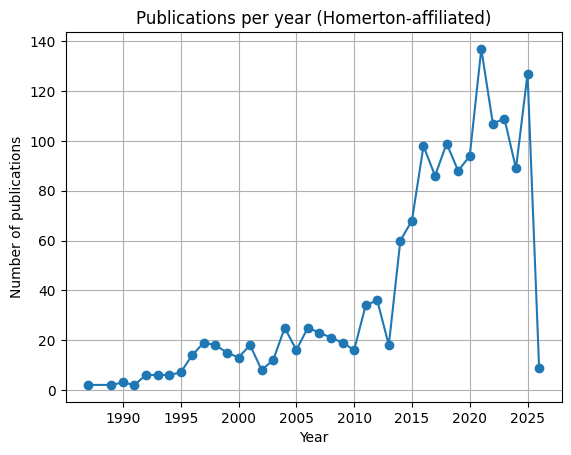

In [83]:
def extract_year(dp):
    if pd.isna(dp):
        return pd.NA
    s = str(dp)

    years = re.findall(r'\b(19\d{2}|20\d{2})\b', s)
    if not years:
        return pd.NA

    # Use the first year in strings like "2003 Dec-2004 Jan"
    return int(years[0])

df['year'] = df['date'].apply(extract_year).astype('Int64')

# Drop rows where year couldn't be parsed
year_counts = (
    df.dropna(subset=['year'])
      .groupby('year')
      .size()
      .sort_index()
)

# Plot
plt.figure()
year_counts.plot(marker='o')
plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.title('Publications per year (Homerton-affiliated)')
plt.grid(True)
plt.savefig("homerton_publications_per_year.png", dpi=300, bbox_inches="tight")
plt.show()

In [79]:
df.year.min()

np.int64(1987)

In [80]:
df.year.max()

np.int64(2026)

In [82]:
df.to_csv('homerton_papers.csv', index=False)